# 2º Trabalho de Engenharia do Conhecimento

Realizado por: Frederico Prazeres (fc56269), Ricardo Sobral (fc56332), Nina Tinga (fc53531), Edson Aníbal (fc57046). 

O trabalho foi dividido em 3 partes: Procura do melhor modelo de classificação, testagem com hiperparamêtros (para o melhor modelo) e seleção das features mais importantes.


## Imports utilizados no projeto

In [128]:
import numpy as np
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, SelectKBest, SequentialFeatureSelector
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import f1_score, make_scorer, matthews_corrcoef, precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, RFECV, SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt

## Procura do melhor modelo de classificação

### 1º Passo: Separação e tratamento dos dados

    [1] - Carrega-se o biobiodegradable_a.csv para uma varíavel data.
    [2] - Transforma valores binários não numéricos em valores binários numéricos.
    [3] - Separa-se as colunas entre x e y, x são as colunas todas menos a última, y é a coluna target.
    [4] - Faz-se uma seleção das colunas que se quer selecionar futuramente (na fase de scaling).
    [5] - Divide-se o dataset. 80% fica para treino e test, 20% para teste independente.
    [6] - Separa-se os dados em conjuntos de treino e teste.
    [7] - Modelo de Cross-Validation utilizado no projeto.

In [129]:
# [1]
data = pd.read_csv('biodegradable_a.csv')
# [2]
le = LabelEncoder()
data['Biodegradable'] = le.fit_transform(data['Biodegradable'])
# [3]
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
# numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
# [4]
all_columns = X.columns.tolist()
columns_not_to_scale = ["F01", "F04", "F03", "F03_CO", "B01", "B04", "B03", "F02_CN"]
columns_to_scale = [col for col in all_columns if col not in columns_not_to_scale]
# [5] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# [7] 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### 2º Passo: Implementação de uma função combined_score, que servirá de métrica para o Cross-Validation

    [1] - Definição dos pesos de cada métrica, deu-se mais importância ao f1 score e ao MCC.
    [2] - A função combined_score, faz a média ponderada de várias métricas.
    [3] - A função que passa as métricas desejadas para o combined_score. Utiliza-se a Accuracy, Recall, Precision, F1-Score e Mathews Correlation Coefficient.
    [4] - Cria-se o scorer utilizando o make_scorer do Scikit-Learn.

In [130]:
# [1]
weights = np.array([0.1, 0.15, 0.30, 0.25, 0.15])  
# [2]
def combined_score(metrics, weights):
    scaler = MinMaxScaler()
    normalized_metrics = scaler.fit_transform(np.array(metrics).reshape(-1, 1))
    # as metricas são normlaizadas para que, por execemplo o mcc que tem uma escala diferente tenha maior peso do qeu as outras metricas
    return np.average(normalized_metrics, weights=weights, axis=0)
# [3]
def combined_score_func(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return combined_score([accuracy, recall, f1, mcc, precision], weights)
#[4]
combined_scorer = make_scorer(combined_score_func)

### 3º Passo: Obtenção do melhor imputer

    [1] - Os modelos de classificação utilizados para o Cross-Validation.
    [2] - Os imputers a testar.
    [3] - O ciclo para encontrar o melhor imputer.
        [3.1] - Para cada modelo de imputing e para cada modelo de classificação obtêm-se os scores de CrossValidation utilizando o combined_scorer como métrica.
        [3.2] - No fim, dá-se print ao melhor imputer.
    [4] - Dropa-se os NaN's e faz-se o Cross-Validation do dataset com NaN's dropados.
    [5] - Dá-se imput ao dataset com o melhor imputer.

In [131]:
print("BEST IMPUTER")
# [1]
models = {
    'K-Nearest Neighbors': KNeighborsClassifier()
}
# [2]
imputers = {
    'Mean': SimpleImputer(strategy='mean'),
    'Median': SimpleImputer(strategy='median'),
    'Most Frequent': SimpleImputer(strategy='most_frequent'),
    'KNN': KNNImputer(n_neighbors=5)
}
# [3]
imputer_scores = {}
best_imputer = None
best_score = 0
for imputer_name, imputer in imputers.items():
    # [3.1]
    X_train_imputed = imputer.fit_transform(X_train)
    # Guarda-se os scores de cada imputer para dar plot
    imputer_scores[imputer_name] = []
    for model_name, model in models.items():
        scores = cross_val_score(model, X_train_imputed, y_train, cv=cv, scoring = combined_scorer)
        mean_score = scores.mean()
        imputer_scores[imputer_name].append(mean_score)
        if mean_score > best_score:
            best_score = mean_score
            best_imputer = imputer_name
        # [3.2]
        print(f"Imputer: {imputer_name}, Model: {model_name}, Mean Score: {mean_score:.8f}")
# [4]
df_train = pd.concat([X_train, y_train], axis=1).dropna()
total_nan_values = X_train.isna().sum().sum()
print(f'Total NaN values in DataFrame: {total_nan_values}')
X_train_dropna = df_train.drop(y.name, axis=1)
y_train_dropna = df_train[y.name]
scores = cross_val_score(models['K-Nearest Neighbors'], X_train_dropna, y_train_dropna, cv=cv, scoring = combined_scorer)
mean_score = scores.mean()
dropna_score = mean_score
# [5]
imputer = imputers[best_imputer]
X_train_imputed = imputer.fit_transform(X_train)
print(f"\nBest Imputer: {best_imputer}, Best Score: {best_score:.8f}")


BEST IMPUTER
Imputer: Mean, Model: K-Nearest Neighbors, Mean Score: 0.63407065
Imputer: Median, Model: K-Nearest Neighbors, Mean Score: 0.63503448
Imputer: Most Frequent, Model: K-Nearest Neighbors, Mean Score: 0.63900356
Imputer: KNN, Model: K-Nearest Neighbors, Mean Score: 0.63680045
Total NaN values in DataFrame: 5562

Best Imputer: Most Frequent, Best Score: 0.63900356


#### Plots (3º Passo)
    [1] - Gráfico de barras que mostra a diferença de performance dos vários imputers testados.
    [2] - Gráfico de barras que compara a performance do melhor imputer com a abordagem de dropar NaN's.

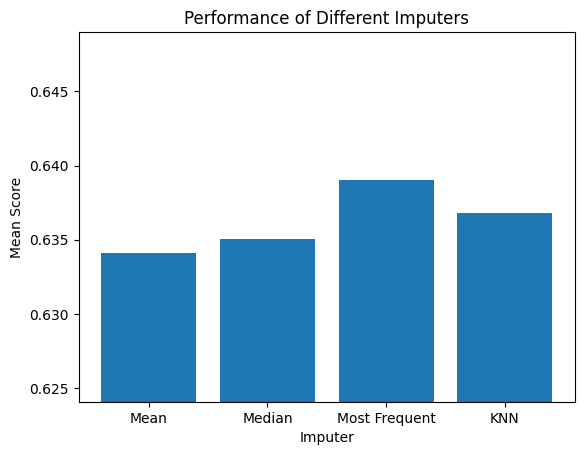

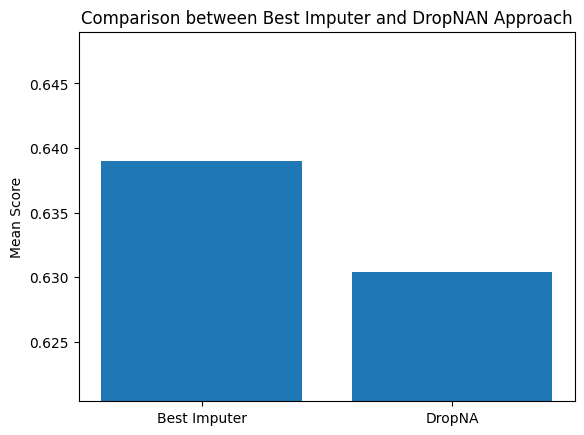

In [132]:
# [1]
fig, ax = plt.subplots()
mean_scores = {imputer: np.mean(scores) for imputer, scores in imputer_scores.items()}
ax.bar(mean_scores.keys(), mean_scores.values())
ax.set_xlabel('Imputer')
ax.set_ylabel('Mean Score')
ax.set_title('Performance of Different Imputers')
min_score = min(mean_scores.values())
max_score = max(mean_scores.values())
ax.set_ylim([min_score - 0.01, max_score + 0.01])
plt.show()
# [2]
labels = ['Best Imputer', 'DropNA']
scores = [best_score, dropna_score]
plt.bar(labels, scores)
plt.ylabel('Mean Score')
plt.title('Comparison between Best Imputer and DropNAN Approach')
# Ajusta-se o eixo Oy para um local onde se possa verificar as diferenças de performance
plt.ylim([min(scores) - 0.01, max(scores) + 0.01])
plt.show()

### 4º Passo: Obtenção do melhor scaler

    [1] - Os scalers a testar.
    [2] - Obter o Cross-Validation score antes do scaling do dataset, para no fim comparar e concluir se o scaling melhorou a performance.
    [3] - O ciclo para encontrar o melhor scaler.
        [3.1] - Guarda-se os melhores scores de cada scaler para dar plot.
        [3.2] - Cria-se um ColumnTransformer para ignorar as colunas selecionadas no ínicio do notebook que não fazem sentido ser escaladas.
        [3.3] - Para cada modelo de scaling e para cada modelo de classificação obtêm-se os scores de CrossValidation utilizando o combined_scorer como métrica.
        [3.4] - No fim, dá-se print ao melhor scaler.
        [3.5] - Print à diferença percentual entre o antes e depois do scaling.
    [4] - Cria o ColumnTransformer com o melhor scaler e transforma o array numpy num DataFrame novamente
    [5] - Aplica-se o scaling (com o Column Transformer) com o melhor scaler ao dataset.

In [133]:
print("BEST SCALER")
# [1]
scalers = {
    'Standard': StandardScaler(),'Min-Max': MinMaxScaler(),'Robust': RobustScaler(),'MaxAbs': MaxAbsScaler()
}
# [2]
print("Before Scaling:")
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_imputed, y_train, cv=cv, scoring=combined_scorer)
    mean_score = scores.mean()
    mean_score_before = scores.mean()
    print(f"Model: {model_name}, Mean Cross-Validation Score: {mean_score:.8f}")
print()
# [3]
best_scaler = None
best_score_scaler = 0
# [3.1]
scaler_scores = {}
for scaler_name, scaler in scalers.items():
    X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train.columns)
    # [3.2]
    preprocessor = ColumnTransformer(
        transformers=[
            ('scale', scaler, columns_to_scale)],
        remainder='passthrough'
    )
    X_train_scaled = preprocessor.fit_transform(X_train_imputed_df)
    # [3.3]
    print(f"Scaler: {scaler_name}")
    for model_name, model in models.items():
        scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring=combined_scorer)
        mean_score = scores.mean()
        if scaler_name not in scaler_scores:
            scaler_scores[scaler_name] = []
            scaler_scores[scaler_name].append(mean_score)
        print(f"Model: {model_name}, Mean Cross-Validation Score: {mean_score:.8f}")
        if mean_score > best_score_scaler:
            best_score_scaler = mean_score
            best_scaler = scaler_name
# [3.4]
print(f"\nBest Scaler: {best_scaler}, Best Score: {best_score_scaler}")
improvement_percentage = (best_score_scaler - mean_score_before) / mean_score_before * 100
# [3.5]
print(f"Improvement after scaling: {improvement_percentage:.4}%")
# [4]
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train.columns)
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', scalers[best_scaler], columns_to_scale)],
    remainder='passthrough' 
)
# [5]
X_train_scaled = preprocessor.fit_transform(X_train_imputed_df)


BEST SCALER
Before Scaling:
Model: K-Nearest Neighbors, Mean Cross-Validation Score: 0.63900356

Scaler: Standard
Model: K-Nearest Neighbors, Mean Cross-Validation Score: 0.64637438
Scaler: Min-Max
Model: K-Nearest Neighbors, Mean Cross-Validation Score: 0.65404578
Scaler: Robust
Model: K-Nearest Neighbors, Mean Cross-Validation Score: 0.64412279
Scaler: MaxAbs
Model: K-Nearest Neighbors, Mean Cross-Validation Score: 0.64951927

Best Scaler: Min-Max, Best Score: 0.6540457800401166
Improvement after scaling: 2.354%


#### Plots (3º Passo)
    [1] - Gráfico de barras que mostra a diferença de performance dos vários scalers testados.
    [2] - Gráfico de barras que compara o antes e depois de dar scale com o melhor scaler.

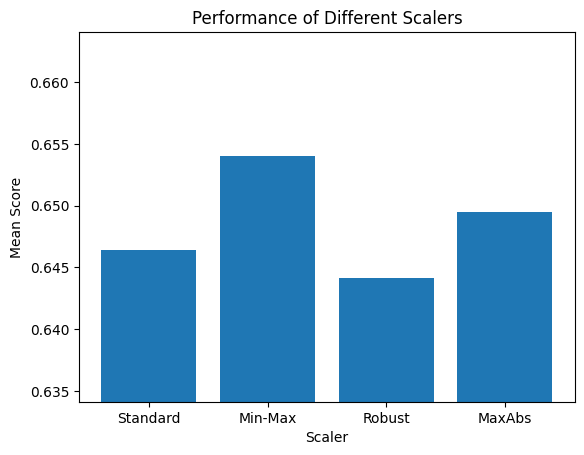

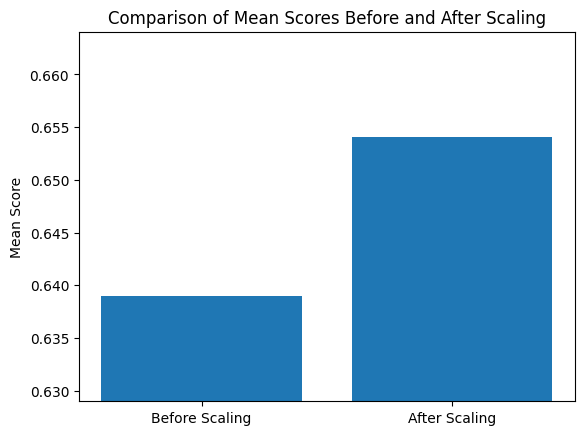

In [134]:
# [1]
fig, ax = plt.subplots()
# Score médio para scaler
mean_scores_scaler = {scaler: np.mean(scores) for scaler, scores in scaler_scores.items()}
# Cria o gráfico de barras
ax.bar(mean_scores_scaler.keys(), mean_scores_scaler.values())
ax.set_xlabel('Scaler')
ax.set_ylabel('Mean Score')
ax.set_title('Performance of Different Scalers')
# Ajusta os limites do eixo y para ampliar as diferenças
min_score_scaler = min(mean_scores_scaler.values())
max_score_scaler = max(mean_scores_scaler.values())
ax.set_ylim([min_score_scaler - 0.01, max_score_scaler + 0.01])  # Ajuste esses valores conforme necessário
plt.show()
# [2]
# Criação do gráfico de barras
labels = ['Before Scaling', 'After Scaling']
scores = [mean_score_before, best_score_scaler]
# Cria o gráfico de barras
plt.bar(labels, scores)
plt.ylabel('Mean Score')
plt.title('Comparison of Mean Scores Before and After Scaling')
# Ajuste os limites do eixo y para ampliar as diferenças
plt.ylim([min(scores) - 0.01, max(scores) + 0.01])  # Ajuste esses valores conforme necessário
plt.show()

### 4º Passo: Obtenção do melhor feature selector

    [1] - Os modelos de feature selection a testar.
    [2] - Obter o Cross-Validation score antes do feature selection do dataset, para no fim comparar e concluir se o feature selection melhorou a performance.
    [3] - O ciclo para encontrar o melhor feature selector.
        [3.1] - Guarda-se os melhores valores de Cross-Validation para cada selector.
        [3.2] - Para cada modelo de feature selection e para cada modelo de classificação obtêm-se os scores de CrossValidation utilizando o combined_scorer como métrica.
        [3.3] - Dá-se print ao melhor feature selector.
        [3.4] - Dá-se print à diferença percentual do Cross-Validation entre o antes e depois do feature selection.
    [4] - No fim, faz-se o feature selection com o melhor feature selector.

In [135]:
print("BEST FEATURE SELECTOR")
# [1]
feature_selectors = {
    'SelectKBest': SelectKBest(),
    'Recursive Feature Elimination': RFECV(estimator=DecisionTreeClassifier(random_state=42)),
    'Stepwise Forward': SequentialFeatureSelector(estimator=DecisionTreeClassifier(random_state=42),n_features_to_select=10,direction='forward',scoring=combined_scorer, cv=cv),
    'Stepwise Backward': SequentialFeatureSelector(estimator=DecisionTreeClassifier(random_state=42),n_features_to_select=10, direction='backward',scoring=combined_scorer, cv=cv),
}
# [2]
print("Cross Validation - Before Selecting Features:")
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring=combined_scorer)
    mean_score = scores.mean()
    print(f"Model: {model_name}, Mean Cross-Validation Score: {mean_score:.8f}")
# [3]
best_selector=None
best_score_selector = 0
# [3.1]
selector_scores = {}
for selector_name, selector in feature_selectors.items():
   # Para métodos Stepwise é necessário aplicar o .fit antes do transform!
    if selector_name in ['Stepwise Forward', 'Stepwise Backward']:
        selector.fit(X_train_scaled, y_train)
        X_train_selected = selector.transform(X_train_scaled)
    else:
        X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    # [3.2]
    print(f"Selector: {selector_name}")
    for model_name, model in models.items():
        scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring=combined_scorer)
        mean_score = scores.mean()
        print(f"Model: {model_name}, Mean Cross-Validation Score: {mean_score:.8f}")
        if selector_name not in selector_scores:
            selector_scores[selector_name] = []
        selector_scores[selector_name].append(mean_score)
        if mean_score > best_score_selector:
            best_score_selector = mean_score
            best_selector = selector_name
# [3.3]
print(f"\nBest Feature Selector: {best_selector}, Best Score: {best_score_selector:.8f}")
# [3.4]
improvement_percentage = (best_score_selector - mean_score_before) / mean_score_before * 100
print()
print(f"Improvement after the selection: {improvement_percentage:.4}%")
# [4]
if best_selector in ['Stepwise Forward', 'Stepwise Backward']:
    # Para métodos Stepwise é necessário aplicar o .fit antes do transform!
    feature_selectors[best_selector].fit(X_train_scaled, y_train)
    X_train_selected = feature_selectors[best_selector].transform(X_train_scaled)
else:
    X_train_selected = feature_selectors[best_selector].fit_transform(X_train_scaled, y_train)

BEST FEATURE SELECTOR
Cross Validation - Before Selecting Features:
Model: K-Nearest Neighbors, Mean Cross-Validation Score: 0.65404578
Selector: SelectKBest
Model: K-Nearest Neighbors, Mean Cross-Validation Score: 0.66428763
Selector: Recursive Feature Elimination
Model: K-Nearest Neighbors, Mean Cross-Validation Score: 0.65404578
Selector: Stepwise Forward
Model: K-Nearest Neighbors, Mean Cross-Validation Score: 0.66581941
Selector: Stepwise Backward
Model: K-Nearest Neighbors, Mean Cross-Validation Score: 0.66129788

Best Feature Selector: Stepwise Forward, Best Score: 0.66581941

Improvement after the selection: 4.197%


#### Plots (4º Passo)   
    [1] - Dá-se plot à diferença de performance entre os feature selectors testados.
    [2] - Dá-se plot aos scores médios (de Cross-Validation), antes e depois do feature selection.

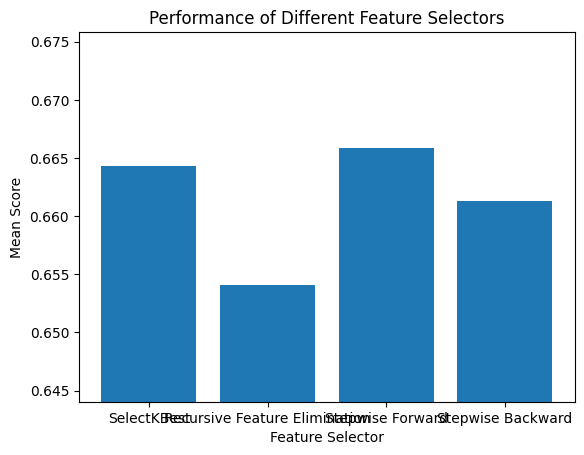

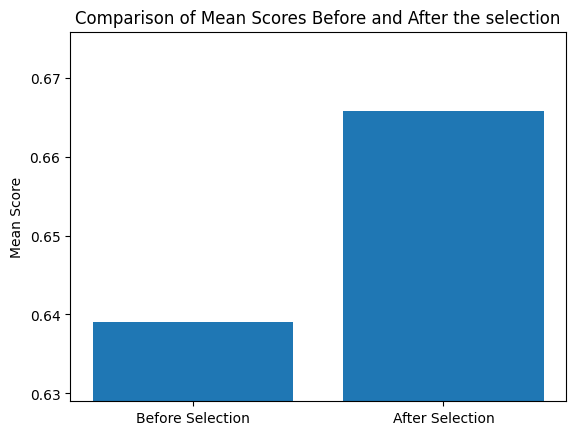

In [136]:
# [1]
fig, ax = plt.subplots()
# Calcula-se o score médio (Cross-Validation) para cada selecionador de features
mean_scores_selector = {selector: np.mean(scores) for selector, scores in selector_scores.items()}
ax.bar(mean_scores_selector.keys(), mean_scores_selector.values())
ax.set_xlabel('Feature Selector')
ax.set_ylabel('Mean Score')
ax.set_title('Performance of Different Feature Selectors')
# Ajusta-se o eixo Oy para um local onde se possa verificar as diferenças de performance
min_score_selector = min(mean_scores_selector.values())
max_score_selector = max(mean_scores_selector.values())
ax.set_ylim([min_score_selector - 0.01, max_score_selector + 0.01])
plt.show()
# [2]
labels = ['Before Selection', 'After Selection']
scores = [mean_score_before, best_score_selector]
plt.bar(labels, scores)
plt.ylabel('Mean Score')
plt.title('Comparison of Mean Scores Before and After the selection')
# Ajusta-se o eixo Oy para um local onde se possa verificar as diferenças de performance
plt.ylim([min(scores) - 0.01, max(scores) + 0.01]) 
plt.show()

### 5º Passo: Mostrar as features mais significativas escolhidas pelo melhor selector

In [137]:
selected_features = np.array(X_train.columns)[feature_selectors[best_selector].get_support()]
print(f"Best features selected by {best_selector} method:")
print(selected_features.tolist())

Best features selected by Stepwise Forward method:
['J_Dz(e)', 'nCb', 'C', 'SM6_L', 'Me', 'nArNO2', 'nCrt', 'F02_CN', 'SM6_B', 'nArCOOR']


### 6º Passo: Obtenção do melhor modelo de classificação

    [1] - Os modelos de classificação a testar.
    [2] - Cross-Validation score antes de aplicar o melhor modelo de classificação, para no fim comparar e concluir se a aplicação do melhor modelo melhorou a performance.
    [3] - O ciclo para encontrar o melhor modelo de classificação.
        [3.1] - Guarda-se o valor de Cross-Validation de cada modelo de classificação.
        [3.2] - Para cada modelo de classificação obtem-se os scores de Cross-Validation utilizando o combined_scorer como métrica.
    [4] - Dá-se print ao melhor modelo de classificação.
    [5] - No fim dá-se plot da diferença de performance entre os vários modelos de classificação


In [138]:
from sklearn.model_selection import GridSearchCV
print("BEST MODEL")
models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'Naive Bayes': GaussianNB()
    }
print(f"Cross Validation score depois do imputing, scaling e feature selection, mas antes de aplicar o melhor modelo de classificação: {best_score_selector:.8f}")
best_model = None
best_model_name = None
best_score = 0
model_scores = {}
for model_name, model in models.items():
    print(f"Model: {model_name}")
    scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring=combined_scorer)
    mean_score = scores.mean()
    model_scores[model_name] = mean_score
    print(f"Model: {model_name}, Mean Cross-Validation Score: {mean_score:.8f}")
    if mean_score > best_score:
        best_score = mean_score
        best_model = model
        best_model_name = model_name
print(f"\nBest Classification Model: {best_model_name}, Best Score: {best_score:.8f}")

BEST MODEL
Cross Validation score depois do imputing, scaling e feature selection, mas antes de aplicar o melhor modelo de classificação: 0.66581941
Model: KNN
Model: KNN, Mean Cross-Validation Score: 0.66581941
Model: Random Forest
Model: Random Forest, Mean Cross-Validation Score: 0.71343217
Model: Decision Tree
Model: Decision Tree, Mean Cross-Validation Score: 0.71942921
Model: SVM
Model: SVM, Mean Cross-Validation Score: 0.64398810
Model: Naive Bayes
Model: Naive Bayes, Mean Cross-Validation Score: 0.64341783

Best Classification Model: Decision Tree, Best Score: 0.71942921


#### Plot (6º Passo)
    [1] - Plot que compara a diferença de performance entre os modelos de classificação testados.
    

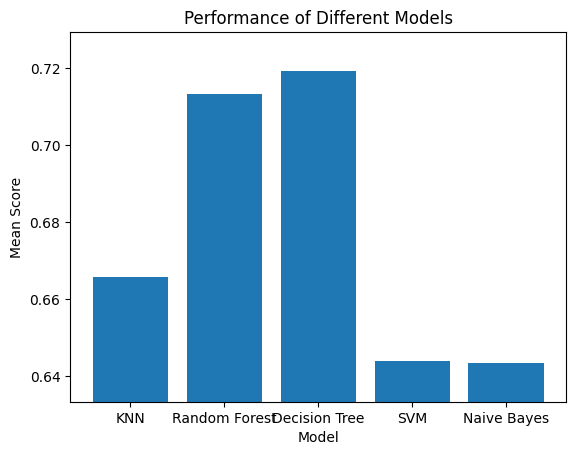

In [139]:
# [1]
fig, ax = plt.subplots()
ax.bar(model_scores.keys(), model_scores.values())
ax.set_xlabel('Model')
ax.set_ylabel('Mean Score')
ax.set_title('Performance of Different Models')
min_score_model = min(model_scores.values())
max_score_model = max(model_scores.values())
ax.set_ylim([min_score_model - 0.01, max_score_model + 0.01])  
plt.show()

### 7º Passo: Hiperparametrização do melhor modelo de classificação
    [1] - Hiperpârametros para os diferentes modelos.
    [2] - Obtêm-se os melhores hiperpârametros.
    [3] - Obtêm-se o melhor score (Cross-Validation) com os melhores hiperpârametros.

In [140]:
param_grids = {
    'KNN': {'n_neighbors': [3, 5, 7]},'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}, 'Naive Bayes': {}, 'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]},
    'Decision Tree': {'max_depth': [None,19,20,21, 22,23], 'min_samples_split': [1,2,3, 5,6,7,14], 'criterion': ['gini', 'entropy'] , "min_samples_leaf": [1,2,3,4], "min_impurity_decrease": [0.0,0.001,0.0001,0.00001, 0.000001]}   
}
best_score_before_optimization = best_score
# [2]
param_grid = param_grids[best_model_name]
grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=cv, scoring=combined_scorer)
grid_search.fit(X_train_selected, y_train)
print(f"Best parameters for, {best_model_name}, :, {grid_search.best_params_}")
# [3]
best_estimator = grid_search.best_estimator_
scores = cross_val_score(best_estimator, X_train_selected, y_train, cv=cv, scoring=combined_scorer)
mean_score = scores.mean()
print(f"Model: {best_model_name}, Mean Cross-Validation Score with best hyperparameters: {mean_score:.8f}")

Best parameters for, Decision Tree, :, {'criterion': 'entropy', 'max_depth': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 6}
Model: Decision Tree, Mean Cross-Validation Score with best hyperparameters: 0.72002338


#### Plot (7º Passo)
    [1] - Plot para comparar a diferença de performance entre o dataset hiperpârametrizado e não hiperpârametrizado.

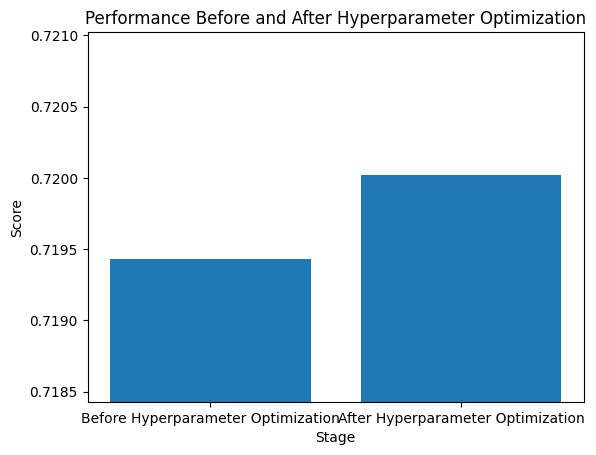

In [141]:
# [1]
best_score_after_optimization = mean_score
scores = {'Before Hyperparameter Optimization': best_score_before_optimization, 'After Hyperparameter Optimization': best_score_after_optimization}
fig, ax = plt.subplots()
ax.bar(scores.keys(), scores.values())
ax.set_xlabel('Stage')
ax.set_ylabel('Score')
ax.set_title('Performance Before and After Hyperparameter Optimization')
# Ajusta-se o eixo Oy para um local onde se possa verificar as diferenças de performance
min_score = min(scores.values()) - 0.001 
max_score = max(scores.values()) + 0.001
ax.set_ylim([min_score, max_score])
plt.show()

### Passo final: Compara-se o dataset excluído no ínicio (20% do total) e dataset optimizado (80%).
    [1] - Dá-se imput, o scale e o feature selection sobre o x_test que corresponde aos 20% que não foram tocados.
    [2] - Faz se o predict dado o x_test processado.

In [142]:
X_test_final_imputed = imputers[best_imputer].transform(X_test)
X_test_imputed_df = pd.DataFrame(X_test_final_imputed, columns=X_train.columns)
X_test_final_scaled = preprocessor.transform(X_test_imputed_df)
if best_selector in ['Stepwise Forward', 'Stepwise Backward']:
    X_test_final_selected = feature_selectors[best_selector].transform(X_test_final_scaled)
else:
    X_test_final_selected = feature_selectors[best_selector].transform(X_test_final_scaled)
# [2] 
predicted_y = best_estimator.predict(X_test_final_selected)
combined_score_final = combined_score_func(y_test, predicted_y)[0]
print("Combined score tested on 20%:", combined_score_final)
difference_percentage = ((best_score_after_optimization - combined_score_final) / combined_score_final) * 100
print(f'Difference between the untouched 20% and the optimized 80%: {difference_percentage:.4f}%')

Combined score tested on 20%: 0.7066048477443256
Difference between the untouched 20% and the optimized 80%: 1.8990%
